In [42]:
# === Cell 1: Imports ===
import os, time, json
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

print("Imports ready")

Imports ready


In [43]:
# === Cell 2: Paths, device setup, and load class weights JSON ===
PROC_DIR = "../data/Processed_v3"
CLASS_WEIGHTS_JSON = "../data/class_frequencies_weights.json"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

class_weights = None
if os.path.exists(CLASS_WEIGHTS_JSON):
    with open(CLASS_WEIGHTS_JSON, "r") as f:
        info = json.load(f)

    # --- normalize structure ---
    if "class_weights" in info:
        cw = info["class_weights"]
    elif "weights" in info:
        cw = info["weights"]
    elif "class_frequencies" in info:
        freqs = info["class_frequencies"]
        if isinstance(freqs, dict):
            vals = np.array(list(freqs.values()), dtype=float)
        else:
            vals = np.array(freqs, dtype=float)
        vals[vals == 0] = 1e-6
        cw = (1.0 / vals) * len(vals)
    else:
        # direct dict of numeric values
        cw = list(info.values())[0] if isinstance(list(info.values())[0], list) else info

    # --- convert dicts to flat list ---
    if isinstance(cw, dict):
        cw = [float(cw[str(i)]) for i in sorted(map(int, cw.keys()))]

    cw = np.array(cw, dtype=float)
    class_weights = torch.tensor(cw, dtype=torch.float32, device=device)
    print("Loaded class_weights:", class_weights.cpu().tolist())

else:
    print("No class weights JSON found, using uniform weights.")
    class_weights = torch.ones(10, device=device)

Using device: mps
Loaded class_weights: [0.13689999282360077, 0.11379999667406082, 0.06120000034570694, 0.0957999974489212, 0.034699998795986176, 0.014800000004470348, 0.010999999940395355, 1.0, 0.946399986743927, 0.0031999999191612005]


In [44]:
# === Cell 3: FloodNet Tiled Dataset (robust + uniform + checksum) ===
from torch.utils.data import Dataset
import os, torch, numpy as np
from PIL import Image
from tqdm import tqdm

class FloodNetTiledDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_size=(512, 512)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size

        img_names = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        mask_names = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

        img_bases = {os.path.splitext(f)[0] for f in img_names}
        mask_bases = {os.path.splitext(f)[0] for f in mask_names}
        valid_bases = sorted(list(img_bases & mask_bases))

        self.pairs = [
            (os.path.join(img_dir, f"{b}.jpg"), os.path.join(mask_dir, f"{b}.png"))
            for b in valid_bases
        ]

        print(f"{len(self.pairs)} matched image–mask pairs "
              f"(skipped {len(img_names)-len(valid_bases)} imgs, {len(mask_names)-len(valid_bases)} masks)")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        # --- Fix any mismatched dimensions ---
        if img.shape[:2] != mask.shape[:2]:
            h, w = min(img.shape[0], mask.shape[0]), min(img.shape[1], mask.shape[1])
            img, mask = img[:h, :w], mask[:h, :w]

        # --- Enforce consistent 512×512 ---
        TARGET_SIZE = self.target_size
        img = Image.fromarray(img).resize(TARGET_SIZE, Image.BILINEAR)
        mask = Image.fromarray(mask).resize(TARGET_SIZE, Image.NEAREST)

        # --- To tensors ---
        img = torch.tensor(np.array(img).transpose(2, 0, 1), dtype=torch.float32) / 255.0
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return img, mask


# === Diagnostic + Checksum Verification ===
print("\nVerifying FloodNet tiles integrity...")
sample_dataset = FloodNetTiledDataset(f"{PROC_DIR}/train_images", f"{PROC_DIR}/train_masks")

unique_classes = set()
shape_issues = 0
for i in tqdm(range(len(sample_dataset)), desc="Checksum"):
    img, mask = sample_dataset[i]
    if img.shape != (3, 512, 512) or mask.shape != (512, 512):
        shape_issues += 1
    unique_classes.update(mask.unique().tolist())

print("\nShape consistency check complete.")
print(f"Tiles checked: {len(sample_dataset)}")
print(f"Mismatched shapes: {shape_issues}")
print(f"Unique mask class IDs found: {sorted(unique_classes)}")

valid_classes = set(range(10))
invalid_classes = unique_classes - valid_classes
if invalid_classes:
    print(f"Warning: Found unexpected class IDs {sorted(invalid_classes)} — check preprocessing!")
else:
    print("All mask classes valid (0–9). Dataset integrity confirmed.")


Verifying FloodNet tiles integrity...
7554 matched image–mask pairs (skipped 0 imgs, 0 masks)


Checksum: 100%|████████████████████████████| 7554/7554 [01:05<00:00, 115.16it/s]


Shape consistency check complete.
Tiles checked: 7554
Mismatched shapes: 0
Unique mask class IDs found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
All mask classes valid (0–9). Dataset integrity confirmed.


In [45]:
# === Cell 4: Dataloaders ===
train_dataset = FloodNetTiledDataset(f"{PROC_DIR}/train_images", f"{PROC_DIR}/train_masks")
val_dataset   = FloodNetTiledDataset(f"{PROC_DIR}/val_images", f"{PROC_DIR}/val_masks")
test_dataset  = FloodNetTiledDataset(f"{PROC_DIR}/test_images", f"{PROC_DIR}/test_masks")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Dataloaders ready.")

7554 matched image–mask pairs (skipped 0 imgs, 0 masks)
888 matched image–mask pairs (skipped 0 imgs, 0 masks)
967 matched image–mask pairs (skipped 0 imgs, 0 masks)
Dataloaders ready.


In [46]:
# === Cell 5: U-Net with ResNet34 backbone ===
from torchvision import models

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.double_conv(x)


class UNetResNet34(nn.Module):
    def __init__(self, n_classes=10, pretrained=True):
        super().__init__()
        base = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)

        self.layer0 = nn.Sequential(*(list(base.children())[:3]))
        self.layer1 = nn.Sequential(*(list(base.children())[3:5]))
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4

        self.center = ConvBlock(512, 512)
        self.dec4 = ConvBlock(512 + 256, 256)
        self.dec3 = ConvBlock(256 + 128, 128)
        self.dec2 = ConvBlock(128 + 64, 64)
        self.dec1 = ConvBlock(64 + 64, 64)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        c = self.center(x4)
        d4 = self.dec4(torch.cat([F.interpolate(c, scale_factor=2), x3], dim=1))
        d3 = self.dec3(torch.cat([F.interpolate(d4, scale_factor=2), x2], dim=1))
        d2 = self.dec2(torch.cat([F.interpolate(d3, scale_factor=2), x1], dim=1))
        d1 = self.dec1(torch.cat([F.interpolate(d2, scale_factor=2), x0], dim=1))
        return self.final(F.interpolate(d1, scale_factor=2))

In [47]:
# === Cell 6: Initialize model, loss, optimizer ===
N_CLASSES = 10
model = UNetResNet34(n_classes=N_CLASSES).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)
try:
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
except TypeError:
    scheduler = None

print(f"Model ready on {device} with {sum(p.numel() for p in model.parameters())/1e6:.2f}M params")

Model ready on mps with 29.22M params


In [48]:
# === Cell 7: Train and validate ===
def train_one_epoch(model, loader, optimizer, criterion, device, max_batches=None):
    model.train()
    total_loss = 0.0
    for i, (imgs, masks) in enumerate(tqdm(loader, desc="Train", leave=False)):
        if max_batches and i >= max_batches: break
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / (i + 1)


def validate(model, loader, criterion, device, n_classes, max_batches=None):
    model.eval()
    total_loss, iou_sum, acc_sum = 0.0, 0.0, 0.0
    n = 0
    per_class_iou = torch.zeros(n_classes, device=device)

    with torch.no_grad():
        for batch_idx, (imgs, masks) in enumerate(tqdm(loader, desc="Val", leave=False)):
            if max_batches and batch_idx >= max_batches:
                break

            try:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
            except FileNotFoundError as e:
                print(f"Skipping missing file during validation: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error in validation batch {batch_idx}: {e}")
                continue

            total_loss += loss.item()
            preds = outputs.argmax(1)

            # IoU + accuracy
            intersection = torch.logical_and(preds == masks, masks > 0)
            union = torch.logical_or(preds > 0, masks > 0)
            iou = intersection.sum().float() / (union.sum().float() + 1e-6)
            acc = (preds == masks).float().mean()

            iou_sum += iou.item()
            acc_sum += acc.item()
            n += 1

    return (
        total_loss / max(1, n),
        iou_sum / max(1, n),
        acc_sum / max(1, n),
        per_class_iou.cpu().numpy().tolist(),
    )

In [49]:
# === Cell 8: Run Training ===
EPOCHS = 10
SAVE_DIR = "../checkpoints_resunet"
os.makedirs(SAVE_DIR, exist_ok=True)

best_miou = 0.0
for epoch in range(EPOCHS):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_miou, val_acc, _ = validate(model, val_loader, criterion, device, N_CLASSES)

    if scheduler: scheduler.step(val_loss)
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"best_epoch{epoch+1}_{val_miou:.4f}.pth"))

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train {train_loss:.4f} | Val {val_loss:.4f} | "
          f"mIoU {val_miou:.4f} | Acc {val_acc:.4f} | {(time.time()-t0):.1f}s")

print("Training complete.")

Epoch [1/10] | Train 1.4711 | Val 1.0631 | mIoU 0.5636 | Acc 0.5657 | 1051.7s


Epoch [2/10] | Train 1.1366 | Val 0.9968 | mIoU 0.5475 | Acc 0.5475 | 1081.8s


Epoch [3/10] | Train 0.9934 | Val 0.9368 | mIoU 0.5806 | Acc 0.5807 | 1037.2s


Epoch [4/10] | Train 0.8784 | Val 0.9378 | mIoU 0.6040 | Acc 0.6045 | 1047.7s


Epoch [5/10] | Train 0.8533 | Val 0.9800 | mIoU 0.5625 | Acc 0.5638 | 1145.9s


Epoch [6/10] | Train 0.7781 | Val 0.8860 | mIoU 0.5775 | Acc 0.5819 | 1146.4s


Epoch [7/10] | Train 0.7480 | Val 0.8086 | mIoU 0.5585 | Acc 0.5609 | 1150.8s


Epoch [8/10] | Train 0.6917 | Val 0.8472 | mIoU 0.5934 | Acc 0.5979 | 1080.1s


Epoch [9/10] | Train 0.6311 | Val 0.7702 | mIoU 0.5393 | Acc 0.5447 | 1098.5s


Epoch [10/10] | Train 0.5996 | Val 0.7126 | mIoU 0.6793 | Acc 0.6802 | 1078.1s
Training complete.


In [50]:
val_loss, val_miou, val_acc, per_class_iou = validate(
    model, val_loader, criterion, device, n_classes=N_CLASSES
)
print(f"Recheck  ➜  Val Loss {val_loss:.4f} | mIoU {val_miou:.4f} | Acc {val_acc:.4f}")

Recheck  ➜  Val Loss 0.7126 | mIoU 0.6793 | Acc 0.6802


In [51]:
torch.save(model.state_dict(), "../checkpoints_resunet/final_epoch10_miou0.6793.pth")

In [56]:
# === Load Final Model Checkpoint for Testing ===
import os, torch

BEST_CKPT = "../checkpoints_resunet/final_epoch10_miou0.6793.pth"

model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
model.to(device)
model.eval()
print(f"Loaded checkpoint: {BEST_CKPT}")

Loaded checkpoint: ../checkpoints_resunet/final_epoch10_miou0.6793.pth


In [57]:
# === Build Test Loader ===
from torch.utils.data import DataLoader
import os, torch

TEST_IMG_DIR = os.path.join("../data/Processed_v3", "test_images")
TEST_MASK_DIR = os.path.join("../data/Processed_v3", "test_masks")

test_dataset = FloodNetTiledDataset(TEST_IMG_DIR, TEST_MASK_DIR)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=False)

print(f"Test set ready: {len(test_dataset)} samples")

967 matched image–mask pairs (skipped 0 imgs, 0 masks)
Test set ready: 967 samples


In [58]:
# === Safe & Compatible Validation Function ===
import numpy as np
from tqdm import tqdm
import torch

def validate(model, loader, criterion, device, n_classes=10, max_batches=None):
    model.eval()
    total_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    inter = np.zeros(n_classes, dtype=np.float64)
    union = np.zeros(n_classes, dtype=np.float64)

    with torch.no_grad():
        for batch_idx, (imgs, masks) in enumerate(tqdm(loader, desc="Val", leave=False)):
            if max_batches and batch_idx >= max_batches: break

            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)

            # Enforce correct dtypes and clip invalid class labels
            masks = masks.long()
            preds = preds.long()
            masks = torch.clamp(masks, 0, n_classes - 1)

            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            # Compute per-class IoU safely
            for cls in range(n_classes):
                pred_mask = (preds == cls)
                true_mask = (masks == cls)
                inter_count = (pred_mask & true_mask).sum().item()
                union_count = (pred_mask | true_mask).sum().item()
                inter[cls] += inter_count
                union[cls] += union_count

    iou = np.divide(inter, union, out=np.zeros_like(inter), where=union != 0)
    mean_iou = np.nanmean(iou)
    acc = correct_pixels / total_pixels if total_pixels > 0 else 0.0
    avg_loss = total_loss / len(loader)

    return avg_loss, mean_iou, acc, iou

In [59]:
# === Run Test Evaluation ===
test_loss, test_miou, test_acc, per_class_iou = validate(
    model, test_loader, criterion, device, n_classes=N_CLASSES
)

print("\nTEST RESULTS")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test mIoU: {test_miou:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nPer-Class IoU:")
for i, v in enumerate(per_class_iou):
    print(f"  Class {i:02d}: {v:.4f}" if not np.isnan(v) else f"  Class {i:02d}: nan")


TEST RESULTS
Test Loss: 0.6214
Test mIoU: 0.4664
Test Accuracy: 0.7200

Per-Class IoU:
  Class 00: 0.0000
  Class 01: 0.7442
  Class 02: 0.6685
  Class 03: 0.3499
  Class 04: 0.5144
  Class 05: 0.6085
  Class 06: 0.7667
  Class 07: 0.2686
  Class 08: 0.3221
  Class 09: 0.4214


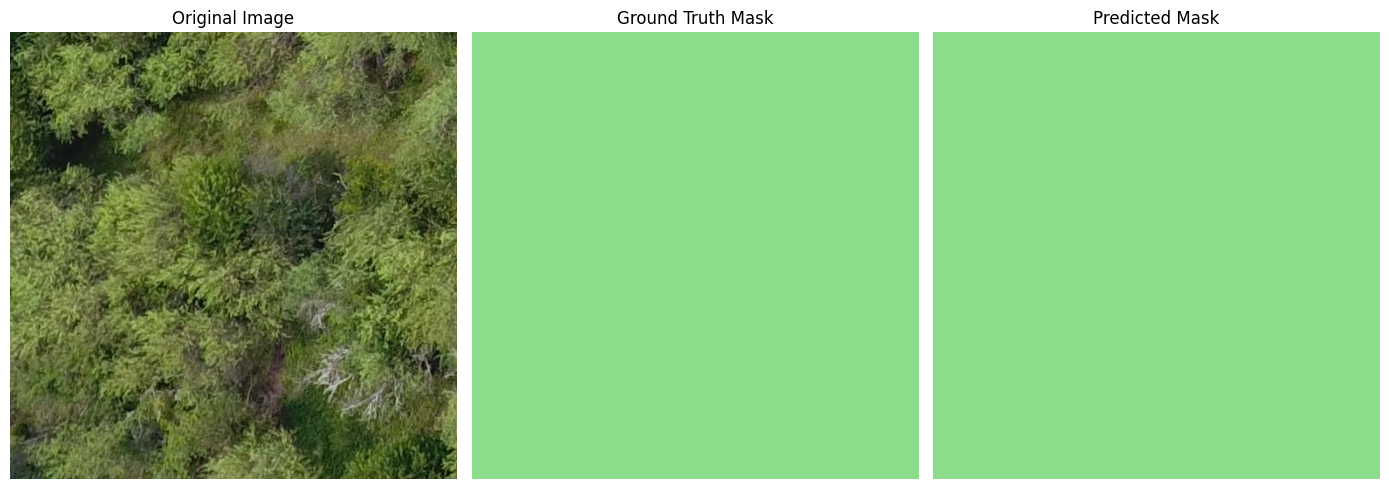

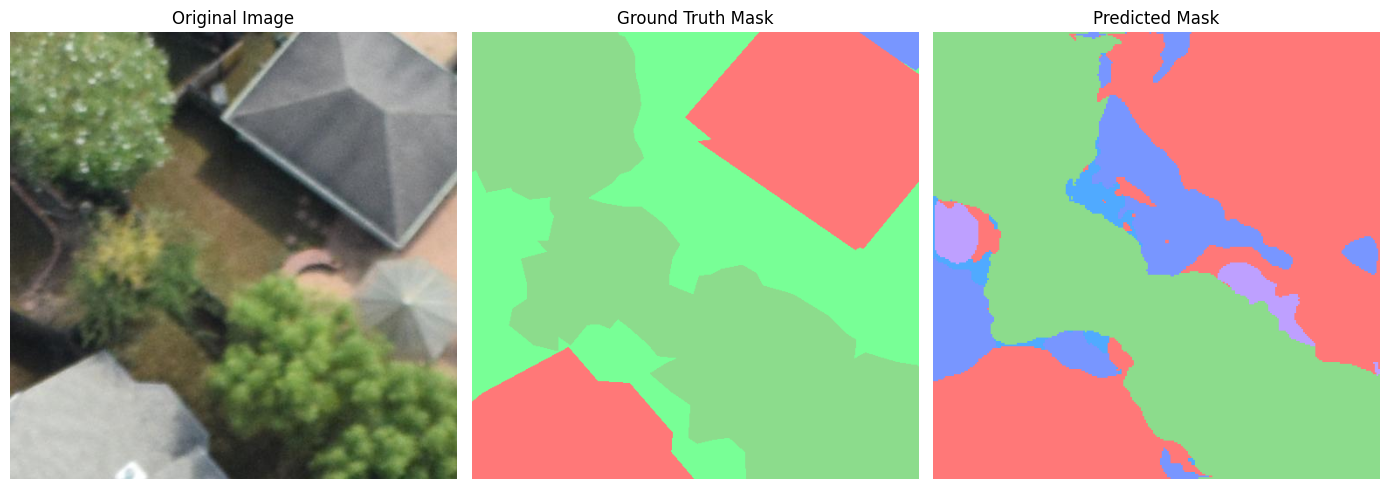

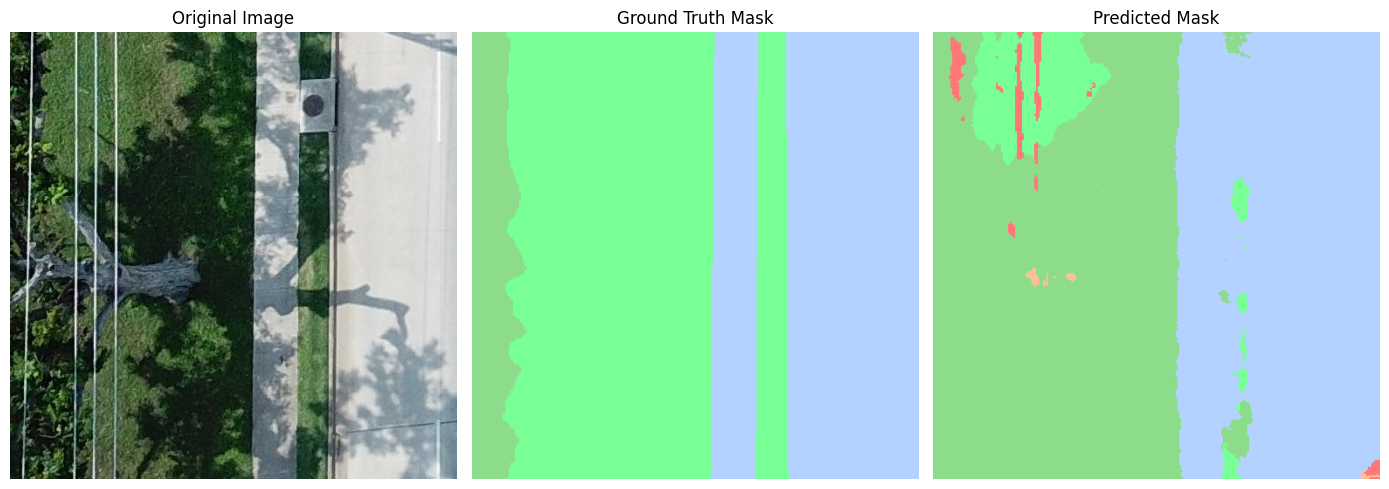

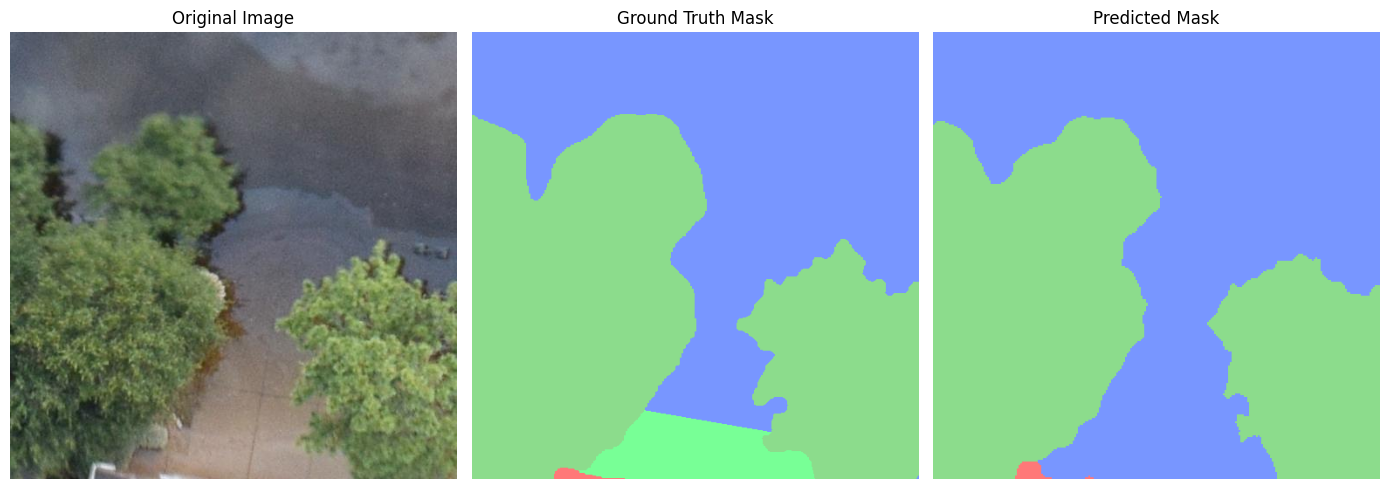

In [75]:
# === Randomized Visualization of Test Predictions ===
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

# Fixed palette (10 classes → 10 RGB colors)
PALETTE = np.array([
    [220, 220, 220],   # 0 - Background (gray)
    [255, 120, 120],   # 1 - Building Flooded (red)
    [255, 190, 150],   # 2 - Building Non-Flooded (peach)
    [120, 150, 255],   # 3 - Road Flooded (dark blue)
    [180, 210, 255],   # 4 - Road Non-Flooded (light blue)
    [80, 170, 255],    # 5 - Water (bright sky blue)
    [140, 220, 140],   # 6 - Tree (green)
    [255, 220, 120],   # 7 - Vehicle (soft yellow)
    [190, 160, 255],   # 8 - Pool (violet)
    [120, 255, 150],   # 9 - Grass (light mint green)
], dtype=np.uint8)

def colorize_mask(mask):
    """Convert (H, W) mask of class IDs to an RGB color mask."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(len(PALETTE)):
        color_mask[mask == cls_id] = PALETTE[cls_id]
    return color_mask

def visualize_random_predictions(model, dataset, num_samples=4, seed=None):
    """Randomly visualize samples from a dataset with predictions."""
    if seed is not None:
        random.seed(seed)
    
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for idx in indices:
            img, gt_mask = dataset[idx]
            img_input = img.unsqueeze(0).to(device)
            pred_mask = model(img_input).argmax(dim=1).cpu().numpy()[0]

            # Convert for display
            img_disp = (img.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
            gt_colored = colorize_mask(gt_mask.numpy())
            pred_colored = colorize_mask(pred_mask)

            # Plot
            fig, axs = plt.subplots(1, 3, figsize=(14, 5))
            axs[0].imshow(img_disp)
            axs[0].set_title("Original Image")
            axs[1].imshow(gt_colored)
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred_colored)
            axs[2].set_title("Predicted Mask")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

# Example: visualize 5 random test samples
visualize_random_predictions(model, test_dataset, num_samples=4, seed=42)

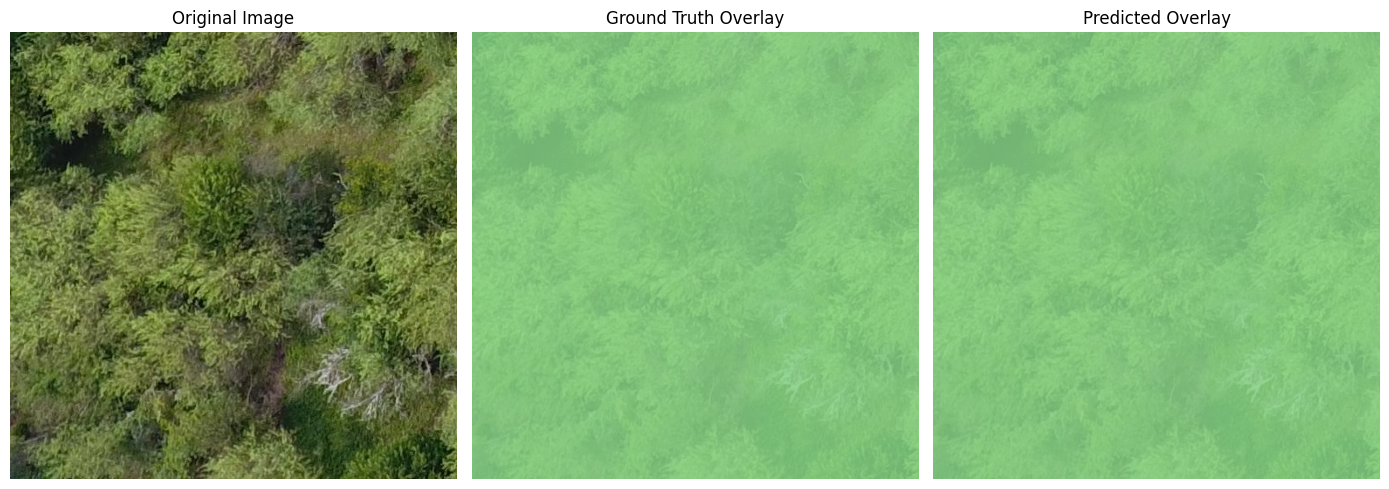

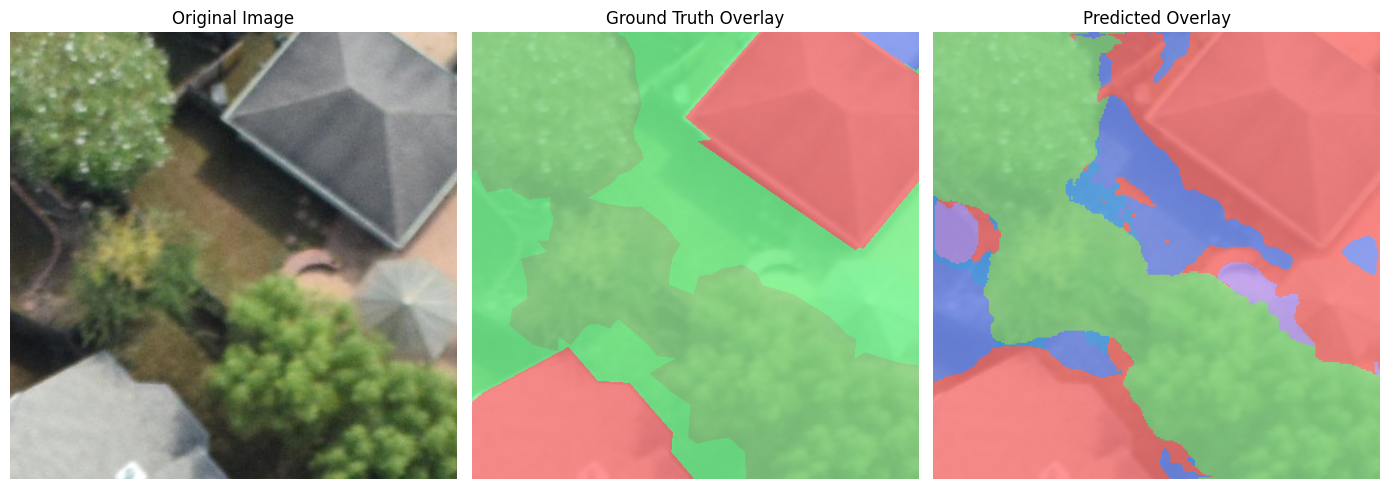

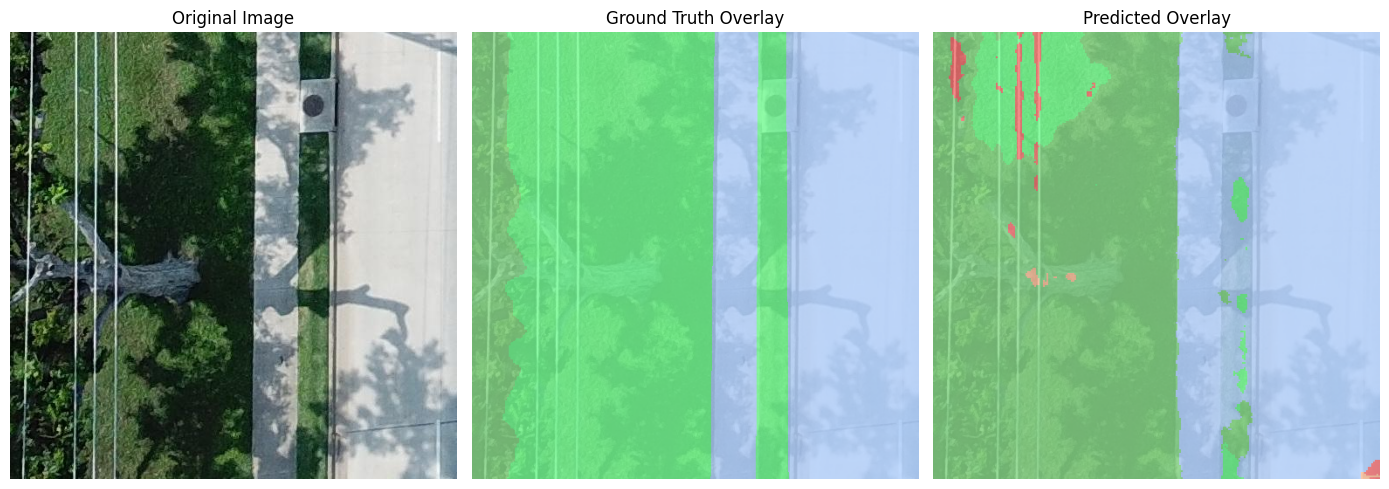

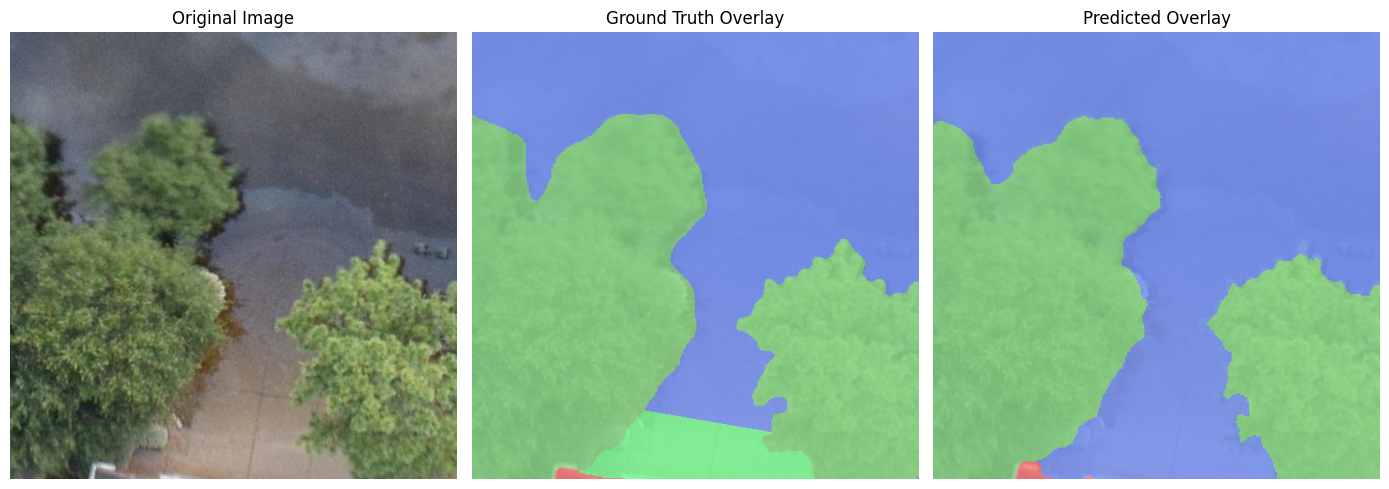

In [78]:
# === Random Overlay Visualization for Test Predictions ===
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import cv2

# Fixed palette (10 classes)
PALETTE = np.array([
    [220, 220, 220],   # 0 - Background (gray)
    [255, 120, 120],   # 1 - Building Flooded (red)
    [255, 190, 150],   # 2 - Building Non-Flooded (peach)
    [120, 150, 255],   # 3 - Road Flooded (dark blue)
    [180, 210, 255],   # 4 - Road Non-Flooded (light blue)
    [80, 170, 255],    # 5 - Water (bright sky blue)
    [140, 220, 140],   # 6 - Tree (green)
    [255, 220, 120],   # 7 - Vehicle (soft yellow)
    [190, 160, 255],   # 8 - Pool (violet)
    [120, 255, 150],   # 9 - Grass (light mint green)
], dtype=np.uint8)

def colorize_mask(mask):
    """Convert (H, W) mask of class IDs to an RGB color mask."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(len(PALETTE)):
        color_mask[mask == cls_id] = PALETTE[cls_id]
    return color_mask

def overlay_mask_on_image(image, mask, alpha=0.5):
    """Overlay the colorized mask on top of the RGB image."""
    color_mask = colorize_mask(mask)
    return cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)

def visualize_random_overlays(model, dataset, num_samples=4, alpha=0.5, seed=None):
    """Show random overlay comparisons: Original, GT Overlay, Pred Overlay."""
    if seed is not None:
        random.seed(seed)

    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for idx in indices:
            img, gt_mask = dataset[idx]
            img_input = img.unsqueeze(0).to(device)
            pred_mask = model(img_input).argmax(dim=1).cpu().numpy()[0]

            # Convert image for visualization
            img_disp = (img.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
            gt_overlay = overlay_mask_on_image(img_disp, gt_mask.numpy(), alpha)
            pred_overlay = overlay_mask_on_image(img_disp, pred_mask, alpha)

            # Plot side-by-side
            fig, axs = plt.subplots(1, 3, figsize=(14, 5))
            axs[0].imshow(img_disp)
            axs[0].set_title("Original Image")
            axs[1].imshow(gt_overlay)
            axs[1].set_title("Ground Truth Overlay")
            axs[2].imshow(pred_overlay)
            axs[2].set_title("Predicted Overlay")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

# Example
visualize_random_overlays(model, test_dataset, num_samples=4, alpha=0.8, seed=42)